In [1]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler, DDIMInverseScheduler
from tqdm import tqdm

generator = torch.Generator().manual_seed(8888)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
torch_dtype = torch.float32

/vol/biomedic3/rrr2417/cxr-generation/notebooks/diffedit_diffusers/lib/python3.9/site-packages/transformers/utils/hub.py:123: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
from dpl.nti_pipeline import StableDiffusionNTI
from dpl.ddim_pipeline import StableDiffusionDDIMInvPipeline

In [3]:
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
LOW_RESOURCE = False

In [4]:
model_path = "/vol/biomedic3/rrr2417/roentgen/roentgen"

In [5]:
ddim = StableDiffusionDDIMInvPipeline.from_pretrained(
    model_path,
    torch_dtype=torch_dtype,
).to(device)
ddim.scheduler = DDIMScheduler.from_config(ddim.scheduler.config)
ddim.inverse_scheduler = DDIMInverseScheduler.from_config(ddim.scheduler.config)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/vol/biomedic3/rrr2417/cxr-generation/notebooks/diffedit_diffusers/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [6]:
from PIL import Image
raw_image = Image.open("p10_p10265727_s54247845.jpg").convert("RGB").resize((512, 512))

In [7]:
all_latents, image, inv_self_avg_dict, inv_cross_avg_dict = ddim(
    prompt="Normal chest radiograph. Specifically, no evidence of pneumonia.", 
    num_inference_steps=NUM_DIFFUSION_STEPS,
    image=raw_image, 
    generator=generator,
)

  0%|          | 0/50 [00:00<?, ?it/s]

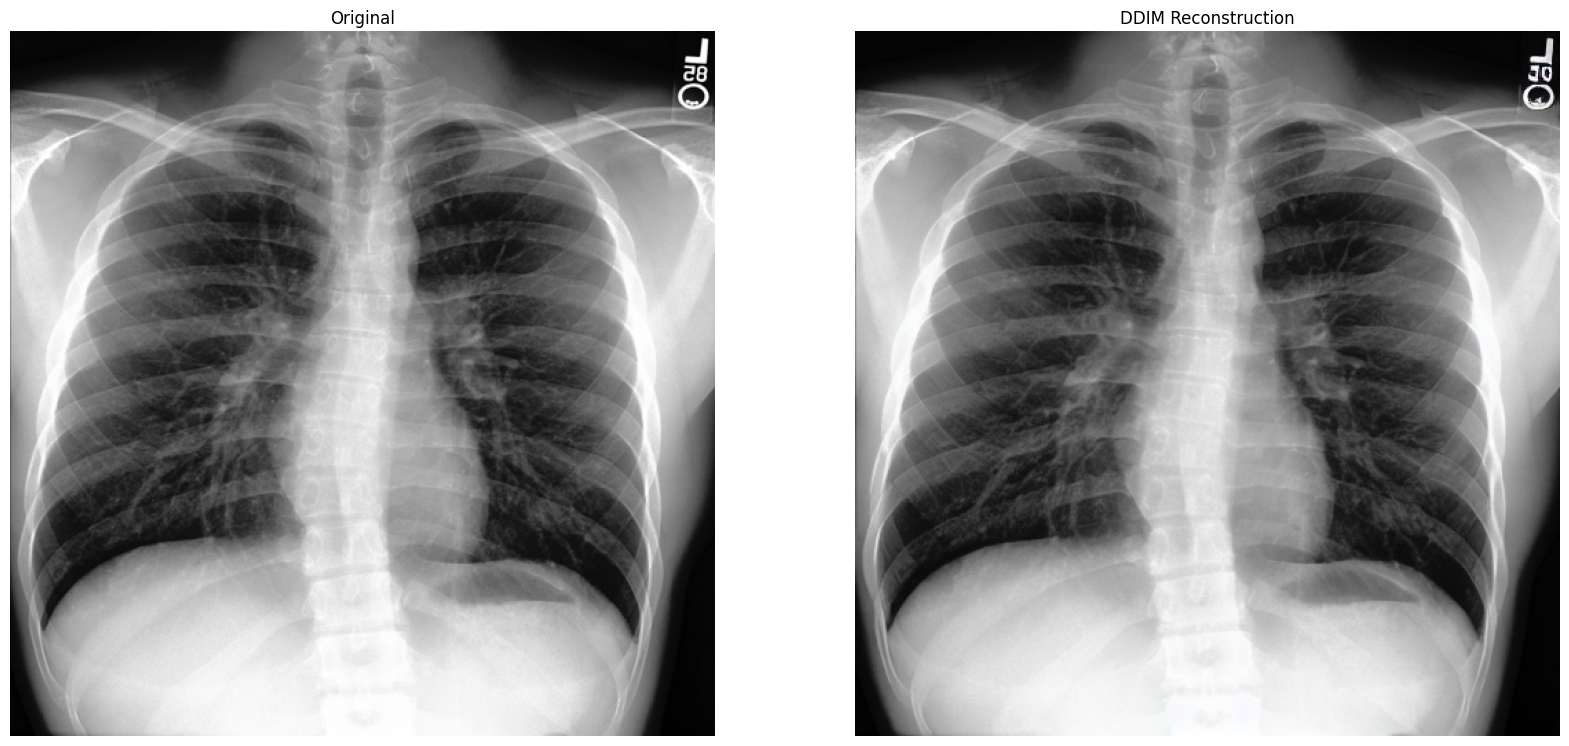

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 40))
ax[0].imshow(raw_image)
ax[0].set_axis_off()
ax[0].set_title("Original")
ax[1].imshow(image[0])
ax[1].set_axis_off()
ax[1].set_title("DDIM Reconstruction")
plt.show()

In [9]:
nti = StableDiffusionNTI.from_pretrained(
    model_path,
    torch_dtype=torch_dtype,
).to(device)

text_encoder = nti.text_encoder
text_encoder.text_model.encoder.requires_grad_(False)
text_encoder.text_model.final_layer_norm.requires_grad_(False)
text_encoder.text_model.embeddings.position_embedding.requires_grad_(False)

nti.scheduler = DDIMScheduler.from_config(nti.scheduler.config)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [ ]:
ddim

## Null-text Inversion

In [13]:
rec_pil_train, attention_maps, uncond_embeddings_list, cond_embeddings_list = pipeline(
    caption,
    num_inference_steps=args.num_ddim_steps,
    latents=inv_latents[-1],
    guidance_scale=args.negative_guidance_scale,
    all_latents = inv_latents,
    print_freq=args.print_freq,
    null_inner_steps=args.null_inner_steps,
    attn_inner_steps=args.attn_inner_steps,
    placeholder_token_id=placeholder_token_id,
    index_no_updates=index_no_updates,
    token_indices = args.indices_to_alter,
    adj_indices_to_alter=adj_indices_to_alter,
    alpha_cos = args.alpha_cos,
    alpha_iou = args.alpha_iou,
    alpha_kl = args.alpha_kl,
    alpha_sim = args.alpha_sim,
    alpha_adj = args.alpha_adj,
    beta_cos = args.beta_cos,
    beta_iou = args.beta_iou,
    beta_kl = args.beta_kl,
    beta_sim = args.beta_sim,
    beta_adj = args.beta_adj,
    lam_cos = args.lam_cos,
    lam_iou = args.lam_iou,
    lam_kl = args.lam_kl,
    lam_sim = args.lam_sim,
    lam_adj = args.lam_adj,
    attn_res=args.attn_res,
    smooth_op=args.smooth_op,
    softmax_op = args.softmax_op,
    seg_maps=det_maps,
    loss_type=args.loss_type,
)

In [8]:
image_path = "p10_p10265727_s54247845.jpg"
prompt = "Normal chest radiograph. Specifically, no evidence of pneumonia."
(image_gt, image_enc), x_t, uncond_embeddings = nti.invert(image_path, prompt, offsets=(0, 0, 200, 0), verbose=True)

print("Modify or remove offsets according to your image!")

DDIM inversion...
Null-text optimization...


100%|███████████████████████████████████████████████████| 500/500 [01:29<00:00,  5.60it/s]

Modify or remove offsets according to your image!


100%|█████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.29it/s]


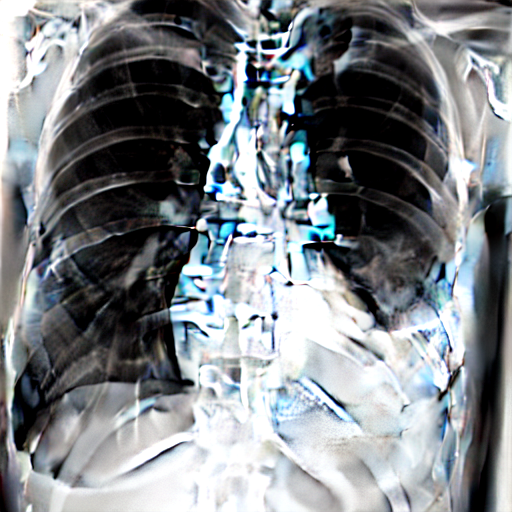

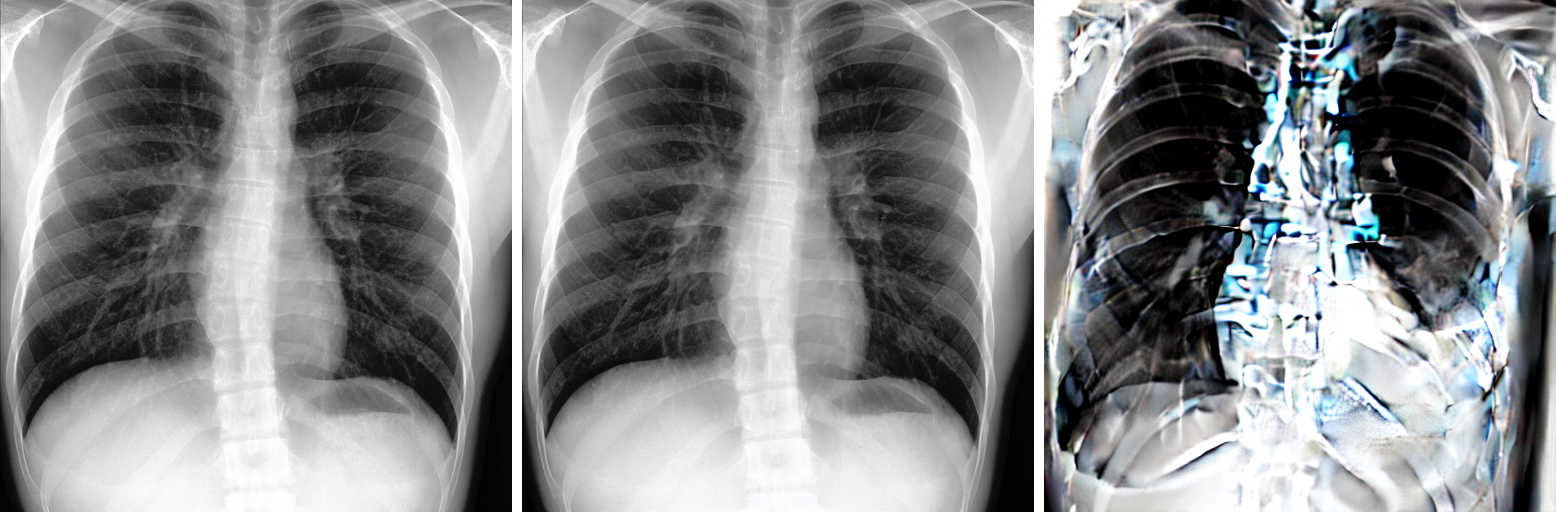

In [9]:
prompts = ["big left-sided pleural effusion"]
controller = AttentionStore(low_resource=LOW_RESOURCE)
image_inv, x_t = run_and_display(ldm_stable, prompts, controller, latent=x_t, uncond_embeddings=uncond_embeddings, run_baseline=False, generator=generator)
view_images([image_gt, image_enc, image_inv[0]])